**Team 24 -- Quantum Sensor Lab -- Development of a Magnetic Field Steering System**

Andrew Fine - Project Manager

Trevor Peterson - Logistics Manager

Steven Coyan - System Engineer

Nate Howard - Software Engineer

Nick Elsasser - Software Engineer

Aaron Li - Software Engineer

Cole Sites - CAD Engineer/Finance Manager

Dean Allison - Manufacturing Engineer

Thomas Brewster - Test Engineer 

---

Questions:

1) How do the coil numbers, sizes, positions, and currents interact to create a magnetic field and how can they be manipulated to change the field?

2) Can we simulate the magnetic field fast enough to test PID control loops in real time?

Ideas:

Implement a basic magnetic field simulation with some simplifying assumptions to get a baseline for how the main coil properties interact with one another to create a magnetic field and also to get a sense of how long it takes to query for the magnetic field at a given (x, y, z). Our simulation is based off of the equations from a paper provided to us by our client. We  also want to be able to take slices of the magnetic field to visualize how the field is created from the coils.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import perf_counter_ns

In [ ]:
#
# Simulation follows an implementation of:
#
# Equations for the Magnetic Field Produced by One
# or More Rectangular Loops of Wire in the Same Plane - Misakian
#
# https://tsapps.nist.gov/publication/get_pdf.cfm?pub_id=10634
#
#

#
# Define helper functions
#

r1 = lambda x, y, z, a1, b1, z0: np.sqrt((a1 + x) ** 2 + (y + b1) ** 2 + (z - z0) ** 2)
r2 = lambda x, y, z, a1, b1, z0: np.sqrt((a1 - x) ** 2 + (y + b1) ** 2 + (z - z0) ** 2)
r3 = lambda x, y, z, a1, b1, z0: np.sqrt((a1 - x) ** 2 + (y - b1) ** 2 + (z - z0) ** 2)
r4 = lambda x, y, z, a1, b1, z0: np.sqrt((a1 + x) ** 2 + (y - b1) ** 2 + (z - z0) ** 2)

d1 = lambda x, y, z, a1, b1, z0: y + b1
d2 = lambda x, y, z, a1, b1, z0: y + b1
d3 = lambda x, y, z, a1, b1, z0: y - b1
d4 = lambda x, y, z, a1, b1, z0: y - b1

c1 = lambda x, y, z, a1, b1, z0: a1 + x
c2 = lambda x, y, z, a1, b1, z0: a1 - x
c3 = lambda x, y, z, a1, b1, z0: -a1 + x
c4 = lambda x, y, z, a1, b1, z0: -a1 - x

def _eval_r(x, y, z, a1, b1, z0):
    return (r1(x, y, z, a1, b1, z0), r2(x, y, z, a1, b1, z0),
            r3(x, y, z, a1, b1, z0), r4(x, y, z, a1, b1, z0))


def _eval_d(x, y, z, a1, b1, z0):
    return (d1(x, y, z, a1, b1, z0), d2(x, y, z, a1, b1, z0),
            d3(x, y, z, a1, b1, z0), d4(x, y, z, a1, b1, z0))


def _eval_c(x, y, z, a1, b1, z0):
    return (c1(x, y, z, a1, b1, z0), c2(x, y, z, a1, b1, z0),
            c3(x, y, z, a1, b1, z0), c4(x, y, z, a1, b1, z0))

In [ ]:
# Magnetic permeability constant
MU_0 = 4 * np.pi * 1.0e-7

#
# Define field component equations, B = <Bx, By, Bz>
#

def Bx(x, y, z, a1, b1, z0, N):
    """
    Magnetic flux density in X direction at point (x, y, z) for a
    coil of size 2*a1, 2*b1 residing on the x, y plane defined by z0

    :param x: x location
    :param y: y location
    :param z: z location
    :param a1: (half of) coil side length A
    :param b1: (half of) coil side length B
    :param z0: Distance of coil from origin
    :param N: Current

    :return: Magnetic flux density
    """

    _k = 100.0 * MU_0 * N / (4 * np.pi)
    _z = z - z0
    _r = _eval_r(x, y, z, a1, b1, z0)
    _d = _eval_d(x, y, z, a1, b1, z0)

    return _k * np.sum([(-1**i) * _z / (_r[i] * (_r[i] + _d[i]))
                        for i in range(4)], axis=0)

def By(x, y, z, a1, b1, z0, N):
    """
    Magnetic flux density in Y direction at point (x, y, z) for a
    coil of size 2*a1, 2*b1 residing on the x, y plane defined by z0

    :param x: x location
    :param y: y location
    :param z: z location
    :param a1: (half of) coil side length A
    :param b1: (half of) coil side length B
    :param z0: Distance of coil from origin
    :param N: Current

    :return: Magnetic flux density
    """

    _k = 100.0 * MU_0 * N / (4 * np.pi)
    _z = z - z0

    _r = _eval_r(x, y, z, a1, b1, z0)
    _c = _eval_c(x, y, z, a1, b1, z0)

    return _k * np.sum([(-1**i) * _z / (_r[i] * (_r[i] + (-1**i) * _c[i]))
                        for i in range(4)], axis=0)

def Bz(x, y, z, a1, b1, z0, N):
    """
    Magnetic flux density in Z direction at point (x, y, z) for a
    coil of size 2*a1, 2*b1 residing on the x, y plane defined by z0

    :param x: x location
    :param y: y location
    :param z: z location
    :param a1: (half of) coil side length A
    :param b1: (half of) coil side length B
    :param z0: Distance of coil from origin
    :param N: Current

    :return: Magnetic flux density
    """

    _k = 100.0 * 1e6 * MU_0 * N / (4 * np.pi)

    # compute each sub-function once and store result
    _r = _eval_r(x, y, z, a1, b1, z0)
    _d = _eval_d(x, y, z, a1, b1, z0)
    _c = _eval_c(x, y, z, a1, b1, z0)

    # return constant * inner sum of various function combinations
    # tried to keep things clean, or at least cleaner than the original mathematica code

    return _k * np.sum([((-1**(i+1))*_d[i] / (_r[i] * (_r[i] + (-1**i)*_c[i]))) -
                        (_c[i] / (_r[i] * (_r[i] - _d[i]))) for i in range(4)], axis=0)

In [ ]:
def get_coil_coordinates(a1, b1, s, N, x, y):
    """
    Get the (x, y) coordinates for the center of the NxN grid of rectangles
    so they satisfy the distances set by the rectangle width, height, and spacing.
    The coils are positioned such that their combined center is at x, y

    :param a1: Rectangle width (x-direction) (cm)
    :param b1: Rectangle height (y-direction) (cm)
    :param s: Spacing between rectangles (cm)
    :param N: Number of rectangles
    :param x: x position of rectangle's center
    :param y: y position of rectangle's center

    :return: np.meshgrid in ij format of each coil's center for NxN grid
    """

    f = lambda x: (s * (N-1) + 2 * x * (N-1)) / 2.0

    f_a1, f_b1 = f(a1), f(b1)
    xx = np.linspace(-1.0 * f_a1, f_a1, num=N) + x
    yy = np.linspace(-1.0 * f_b1, f_b1, num=N) + y

    return np.meshgrid(xx, yy)

def get_field(x, y, z, a1, b1, z0, current, num_coils, coil_spacing):
    """
    Compute the magnetic field at (x, y, z) created by N^2 coils on plane z0 arranged in 
    an NxN grid with equal spacing and current

    :param x: x coordinate to query (cm)
    :param y: y coordinate to query (cm)
    :param z: z coordinate to query (cm)
    :param a1: Half of the rectangle width (cm)
    :param b1: Half of the rectangle height (cm)
    :param z0: z coordinate plane goes through
    :param current: Current through all coils
    :param num_coils: Number of coils per row in grid, total coils is NxN
    :param coil_spacing: Spacing between coils (cm)

    :return: np.array containing the field x, y, z components in that order
    """
    xx, yy = get_coil_coordinates(a1, b1, coil_spacing, num_coils, x, y)

    bx, by, bz = None, None, None
    for i in range(num_coils):
        for j in range(num_coils):
            if bx is None:
                bx = Bx(xx[i, j], yy[i, j], z, a1, b1, z0, current[i + j*num_coils])
            else:
                bx += Bx(xx[i, j], yy[i, j], z, a1, b1, z0, current[i + j*num_coils])

            if by is None:
                by = By(xx[i, j], yy[i, j], z, a1, b1, z0, current[i + j*num_coils])
            else:
                by += By(xx[i, j], yy[i, j], z, a1, b1, z0, current[i + j*num_coils])

            if bz is None:
                bz = Bz(xx[i, j], yy[i, j], z, a1, b1, z0, current[i + j*num_coils])
            else:
                bz += Bz(xx[i, j], yy[i, j], z, a1, b1, z0, current[i + j*num_coils])

    return np.array([bx, by, bz])

def overlay_coils(a1, b1, num_coils, coil_spacing, unit, ax):
    """
    Overlay where the coils would be on the x, y plane in the magnetic field plot

    :param a1: half of the coil width (cm)
    :param b1: half of the coil height (cm)
    :param num_coils: Number of coils per row
    :param coil_spacing: Spacing between coils (cm)
    :param unit: Conversion between cm and matplotlib pixel units
    :param ax: matplotlib graph to apply overlay to
    """

    # convert coil sizes to matplotlib units
    a1 *= unit
    b1 *= unit
    coil_spacing *= unit

    f = lambda x: (coil_spacing * (num_coils - 1) + 2 * x * (num_coils - 1)) / 2.0

    f_a1, f_b1 = f(a1), f(b1)

    # shift up and over s.t. we have the top left corner of each coil
    xp = np.linspace(-1.0 * f_a1 + 50, f_a1 + 50, num=num_coils) - a1
    yp = np.linspace(-1.0 * f_b1 + 50, f_b1 + 50, num=num_coils) - b1
    xx, yy = np.meshgrid(xp, yp)
    for i in range(num_coils):
        for j in range(num_coils):
            px, py = xx[i, j], yy[i, j]
            print(px, py, 2*a1, 2*b1)
            rect = plt.Rectangle((px, py), 2*a1, 2*b1, fc='none', ec='green', lw=2.0, alpha=0.75)
            ax.add_patch(rect)

def overlay_coilsY(a1, b1, num_coils, coil_spacing, unit, ax):
    # convert coil sizes to matplotlib units
    a1 *= unit
    b1 *= unit
    coil_spacing *= unit

    f = lambda x: (coil_spacing * (num_coils - 1) + 2 * x * (num_coils - 1)) / 2.0

    f_a1, f_b1 = f(a1), f(b1)

    # shift up and over s.t. we have the top left corner of each coil
    xp = np.linspace(-1.0 * f_a1 + 50, f_a1 + 50, num=num_coils) - a1
    yp = np.linspace(-1.0 * f_b1 + 50, f_b1 + 50, num=num_coils) - b1
    xx, yy = np.meshgrid(xp, yp)
    for i in range(num_coils):
        for j in range(num_coils):
            if i==1:
                continue
            px, py = xx[i, j], yy[i, j]
            #print(px, py, 2*a1, 2*b1)
            rect = plt.Rectangle((px, py+(2*unit)),2*a1,.5, fc='none', ec='green', lw=2.0, alpha=0.75)
            ax.add_patch(rect)

def overlay_coilsX(a1, b1, num_coils, coil_spacing, unit, ax):
    # convert coil sizes to matplotlib units
    a1 *= unit
    b1 *= unit
    coil_spacing *= unit

    f = lambda x: (coil_spacing * (num_coils - 1) + 2 * x * (num_coils - 1)) / 2.0

    f_a1, f_b1 = f(a1), f(b1)

    # shift up and over s.t. we have the top left corner of each coil
    xp = np.linspace(-1.0 * f_a1 + 50, f_a1 + 50, num=num_coils) - a1
    yp = np.linspace(-1.0 * f_b1 + 50, f_b1 + 50, num=num_coils) - b1
    xx, yy = np.meshgrid(xp, yp)
    for i in range(num_coils):
        for j in range(num_coils):
            if j==1:
                continue
            px, py = xx[i, j], yy[i, j]
            #print(px, py, 2*a1, 2*b1)
            rect = plt.Rectangle((px+(2*unit), py), .5, 2*b1, fc='none', ec='green', lw=2.0, alpha=0.75)
            ax.add_patch(rect)
            
def create_field_wall(a1, b1, I_wall_1, I_wall_2, spacing, N, wall_spacing, val, const='z'):
    # define some random constants to plot
    axis_1 = np.linspace(-10, 10, num=100)
    axis_2 = np.linspace(-10, 10, num=100)

    assert len(I_wall_1) == N * N
    assert len(I_wall_2) == N * N

    # A1 and B1 are (half of) the rectangle length and width
    A1, B1, I, spacing = 2, 2, 1, 1.0

    GRID = N
    xx, yy = get_coil_coordinates(A1, B1, spacing, GRID, 0, 0)
    size = max((GRID-1), 1) * A1 * spacing * 2

    grid = np.zeros((100, 100))

    field_axis1 = np.linspace(-size, size, 100)
    field_axis2 = np.linspace(-size, size, 100)

    unit = 100 / (2*size) # convert cm grid (2*size x 2*size) to matplotlib unit grid (100x100 plot)
    for i, ax1 in enumerate(field_axis1):
        for j, ax2 in enumerate(field_axis2):
            # get the magnitude of the field at each x, y
            if const == 'z':
              _b1 = get_field(ax1, ax2, val, A1, B1, wall_spacing, I_wall_1, GRID, spacing)
              grid[i, j] = np.linalg.norm(_b1, axis=0)

    return grid


def plot_field(grid, val, A1, B1, GRID, spacing, unit, axis_1, axis_2, field_axis_1, field_axis_2):
    # plot the grid
    xticks = ['' if i % 10 else f'{axis_1[i]:.2f}' 
              for i in range(len(field_axis1))][:-1] + [field_axis1[-1]]
    yticks = ['' if i % 10 else f'{axis_2[i]:.2f}' 
              for i in range(len(field_axis2))][:-1] + [field_axis2[-1]]
    ax = sns.heatmap(grid, xticklabels=xticks, yticklabels=yticks)
    
    if const == 'z':
        overlay_coils(A1, B1, GRID, spacing, unit, ax)

        plt.title(f'Magnetic Field Magnitude (nT) of a {GRID}x{GRID} of Coils at Z={val}cm.')
        plt.xlabel('X position (cm)')
        plt.ylabel('Y position (cm)')

        plt.show()

In [ ]:
# Define parameters for our simulation that are similar to our actual parameters (so far)

# wall size
wall_size = 160.0 # cm

# number of coils
N = 1

spacing = 10.0 # cm

# square coils, 4x4 grid taking up 1.6m x 1.6m, 160 / 4 - spacing * 3 = 
a1 = (wall_size / N) - (spacing * (N-1)) # cm
b1 = a1 # cm

# 1.4m of separation, let the origin be directly at the center
sep = 140.0 # cm
z_wall_1 = sep / 2.0 # cm
z_wall_2 = -z_wall_1 # cm

# for now have the current be exactly the same for all coils
I = np.repeat(1.0, N) # Amps

# time querying field between the walls at 0, 0, 0
s = perf_counter_ns()
B = get_field(0, 0, 0, a1, b1, z_wall_1, I, N, spacing) + get_field(0, 0, 0, a1, b1, z_wall_2, -I, N, spacing)
e = perf_counter_ns() - s
print(f'Time to query field: {e/1e6:.2f} milliseconds')

Time to query field: 0.85 milliseconds


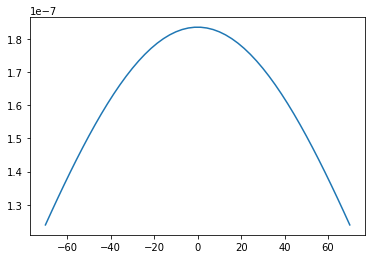

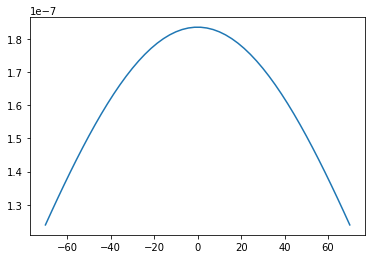

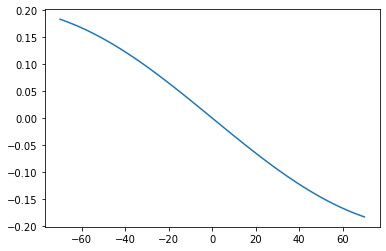

In [ ]:
z = np.linspace(z_wall_2, z_wall_1)
_b = get_field(0, 0, z, a1, b1, z_wall_1, I, N, spacing) + get_field(0, 0, z, a1, b1, z_wall_2, -I, N, spacing)
plt.plot(z, _b[0], label='x')
plt.show()
plt.plot(z, _b[1], label='y')
plt.show()
plt.plot(z, _b[2], label='z')
plt.show()

In [ ]:
# create_field(a1, b1, np.repeat(I, N*N), -1.0 * np.repeat(I, N*N), spacing, N, sep, val=0)


Insights gained from prototype:

1) With a simulation we are easily able to see how the variable coil parameters interact with each other to create the magnetic field. As our design changes we can change our simulation to follow and quickly see how any changes would impact the overall performance of magnetic field generation.

2) We also see that our simulation provides a good first step to simulating and testing our PID loops as it only takes a couple milliseconds to query one point in the field. We are also able to visualize our magnetic fields and coils through our simulation. Given better parallization of the code we may be able to speed up the visualizations to near real time, and we are also looking into full 3d visualizations of the coils and magnetic field as a next step for the simulation.

In [ ]:
def get_b_matrix(x, y, z, coil_spacing, a1, b1, wall_spacing, N):
  B_hat = np.zeros((3, N*N*2))


  # row 1 is the x field (I=1.0) for each coil 0...N*N*2. The first N*N entries
  # are the first wall coils, last N*N are the second wall coils.
  # Same idea for rows 2 and 3 :)

  xx, yy = get_coil_coordinates(a1, b1, coil_spacing, N, x, y)
  z0 = wall_spacing / 2.0
  for i in range(N*N*2):
    _z0 = -z0 if i < N*N else z0 # get correct wall for the coil number
    _i, _j = (i // N) % N, (i % N) % N # get correct indices

    # current = 1.0 as placeholder since solving for current
    B_hat[0, i] = Bx(xx[_i, _j], yy[_i, _j], z, a1, b1, _z0, 1.0)
    B_hat[1, i] = By(xx[_i, _j], yy[_i, _j], z, a1, b1, _z0, 1.0)
    B_hat[2, i] = Bz(xx[_i, _j], yy[_i, _j], z, a1, b1, _z0, 1.0)
  
  return B_hat



In [ ]:
# wall size
wall_size = 160.0 # cm

# number of coils
N = 2

spacing = 10.0 # cm

# square coils, 4x4 grid taking up 1.6m x 1.6m, 160 / 4 - spacing * 3 = 
a1 = (wall_size / N) - (spacing * (N-1)) # cm
b1 = a1 # cm

# 1.4m of separation, let the origin be directly at the center
sep = 140.0 # cm

# test point
x_v = np.array([0., 0., 0.])

# ambient (measured) field at test point
A = np.array([-1., -1., -1.]) * 1e-6

# solve BI = -A
# B_hat is 3x(N*N*2) matrix, I is (N*N*2)x1 vector, A is 3x1 vector
B_hat = get_b_matrix(*x_v, spacing, a1, b1, sep, N)

x_np = np.linalg.lstsq(B_hat, -A, rcond=None)[0]

In [ ]:
import cvxpy as cp

def error_plot(r, num_loops, start, stop):
  consts = np.logspace(start, stop, num=1000)
  errs = np.zeros(consts.shape)
  for i, c in enumerate(consts):
    x = cp.Variable(N*N*2)
    objective = cp.Minimize(cp.norm_inf(B_hat @ x - r))
    constraints = [-c * num_loops <= x, x <= c * num_loops]
    prob = cp.Problem(objective, constraints).solve()
    errs[i] = max(B_hat @ np.array(x.value) - r)

  return consts[1:], errs[1:]


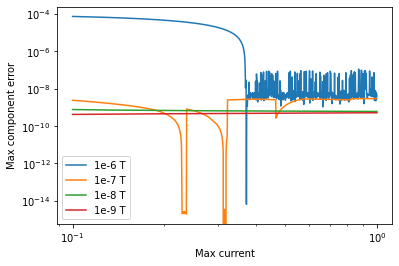

In [ ]:
L = 100

consts, errs_0 = error_plot(np.array([-1, -1, -1]) * 1e-4, L, -1.001, 0)
plt.loglog(consts, errs_0, label='1e-6 T')


consts, errs_1 = error_plot(np.array([-1, -1, -1]) * 1e-5, L, -1.001, 0)
plt.loglog(consts, errs_1, label='1e-7 T')

consts, errs_2 = error_plot(np.array([-1, -1, -1]) * 1e-6, L, -1.001, 0)
plt.loglog(consts, errs_2, label='1e-8 T')

consts, errs_3 = error_plot(np.array([-1, -1, -1]) * 1e-7, L, -1.001, 0)
plt.loglog(consts, errs_3, label='1e-9 T')


plt.ylabel('Max component error')
plt.xlabel('Max current')
plt.legend()
plt.show()


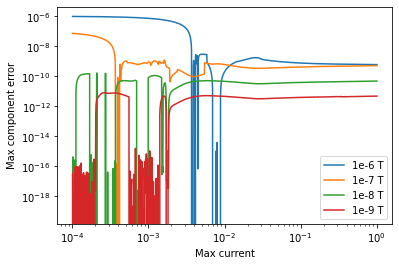

In [ ]:
L = 100

consts, errs_0_0 = error_plot(np.array([-1, -1, -1]) * 1e-6, L, -4.001, 0.001)
plt.loglog(consts, errs_0_0, label='1e-6 T')


consts, errs_1_1 = error_plot(np.array([-1, -1, -1]) * 1e-7, L, -4.001, 0.001)
plt.loglog(consts, errs_1_1, label='1e-7 T')

consts, errs_2_2 = error_plot(np.array([-1, -1, -1]) * 1e-8, L, -4.001, 0.001)
plt.loglog(consts, errs_2_2, label='1e-8 T')

consts, errs_3_3 = error_plot(np.array([-1, -1, -1]) * 1e-9, L, -4.001, 0.001)
plt.loglog(consts, errs_3_3, label='1e-9 T')


plt.ylabel('Max component error')
plt.xlabel('Max current')
plt.legend()
plt.show()


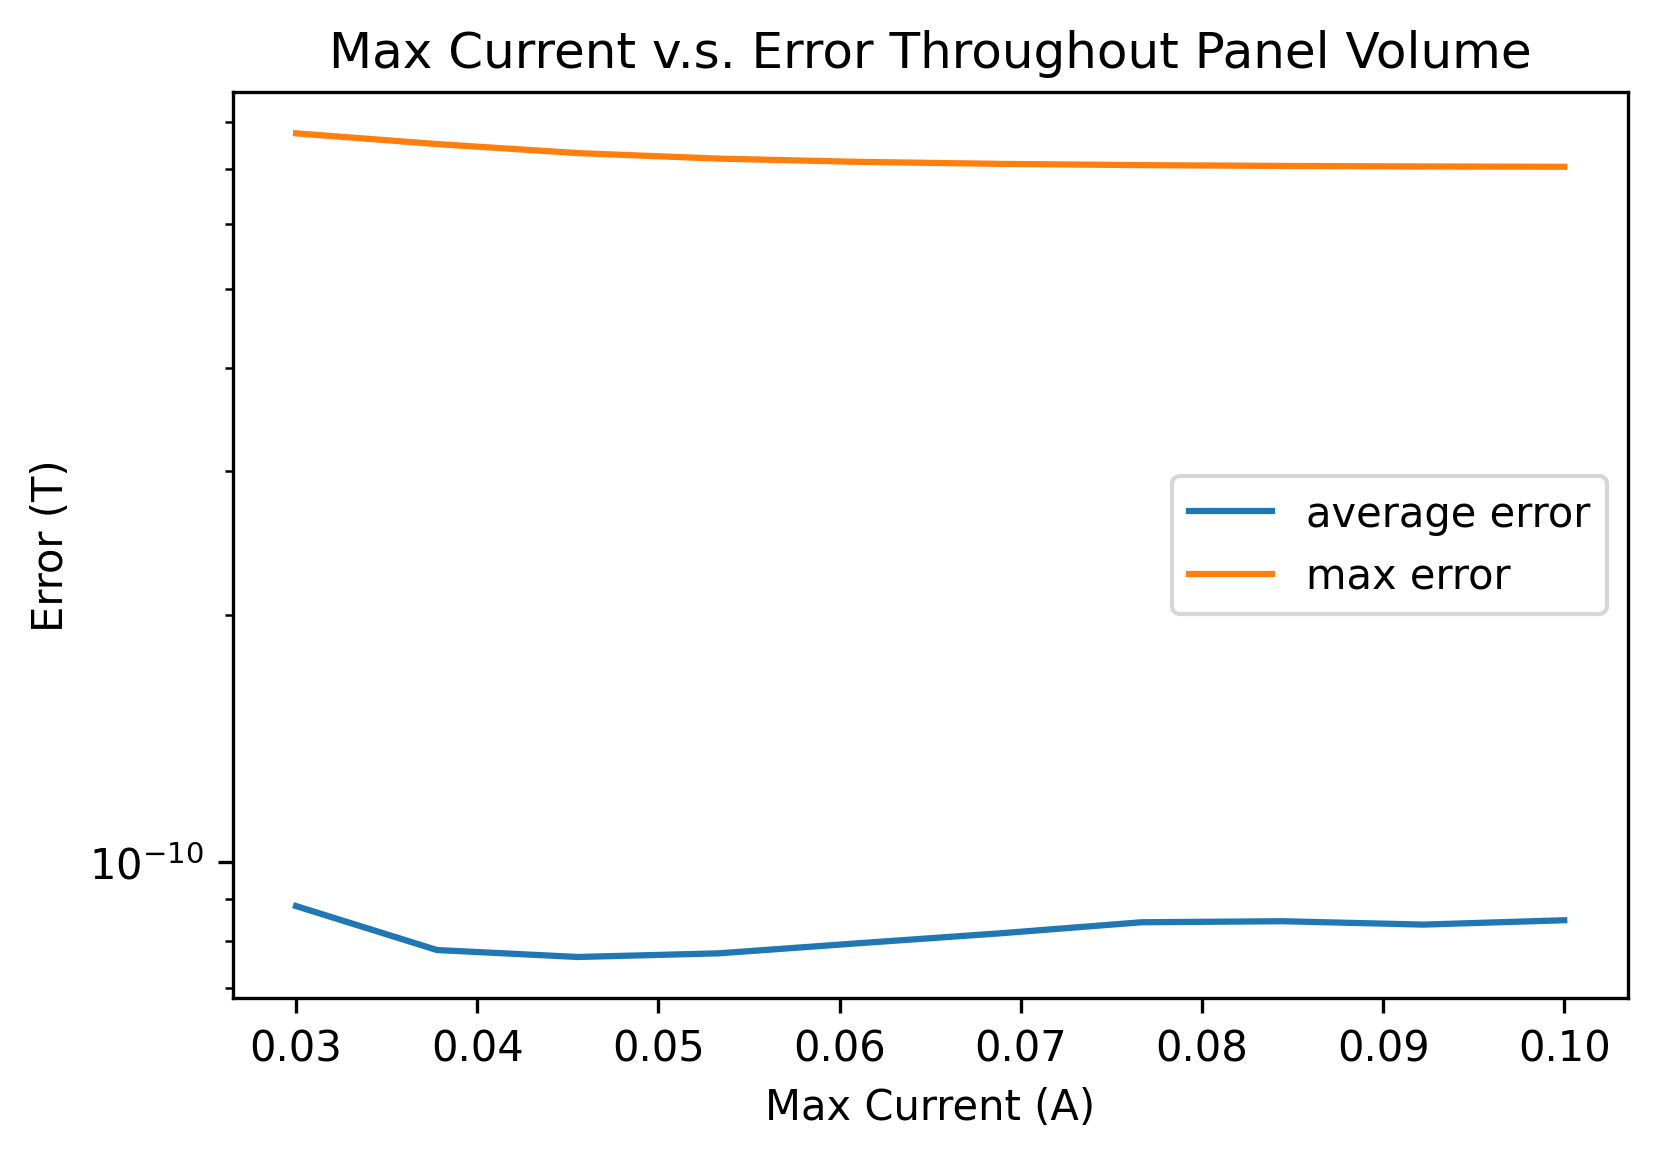

In [ ]:
currents = np.linspace(30e-3, 100e-3, num=10)
max_errs, avg_errs, min_errs = [], [], []

eps = 5 #cm

min_x = (-wall_size / 2) + eps
max_x = -min_x

min_y = (-wall_size / 2) + eps
max_y = -min_y

min_z = (-sep / 2) + eps
max_z = -min_z
N = 4
for c in currents:
  sub_errs = np.zeros(1000)
  for i in range(1000):
    p = (min_x + (i%10)*(max_x - min_x)/10, # x-index * step size
         min_y + ((i//10)%10)*(max_y - min_y)/10, # y-index * step size
         min_z + (i//100)*(max_z - min_z)/10) # z-index * step size
    B_hat = get_b_matrix(*p, spacing, a1, b1, sep, N)
    x = cp.Variable(N*N*2)
    cp.Problem(cp.Minimize(cp.norm_inf(B_hat @ x - A)), [-c * 100 <= x, x <= c * 100]).solve()
    sub_errs[i] = max(B_hat @ np.array(x.value) - A)

  max_errs.append(np.max(sub_errs))
  avg_errs.append(np.mean(sub_errs))

plt.plot(currents, avg_errs, label='average error')
plt.plot(currents, max_errs, label='max error')
plt.yscale('log')
plt.legend()
plt.rcParams['figure.dpi'] = 300
plt.title('Max Current v.s. Error Throughout Panel Volume')
plt.ylabel('Error (T)')
plt.xlabel('Max Current (A)')
plt.show()

7.625265055144173e-10

In [ ]:
def solver(x, y, z, coil_spacing, a1, b1, wall_spacing, residual_field, I_current, I_max, N):
  B_hat = get_b_matrix(x, y, z, coil_spacing, a1, b1, wall_spacing, N)

  x_prime = cp.Variable(N*N*2)

  objective = cp.Minimize(cp.norm_inf(B_hat @ x_prime - residual_field))
  constraints = [-I_max - I_current <= x_prime, x_prime <= I_max - I_current]

  cp.Problem(objective, constraints).solve()

  return I_current + np.array(x_prime.value)


In [ ]:
# wall size
wall_size = 160.0 # cm

# number of coils
N = 4

coil_spacing = 10.0 # cm

# square coils, 4x4 grid taking up 1.6m x 1.6m, 160 / 4 - spacing * 3 = 
a1 = (wall_size / N) - (spacing * (N-1)) # cm
b1 = a1 # cm

# 1.4m of separation, let the origin be directly at the center
wall_spacing = 140.0 # cm

# test point
p = np.array([0., 0., 0.])

# residual (measured) field at test point
residual_field = np.array([-1., -1., -1.]) * 1e-6

# initial current is 0 for all panels
I_0 = np.zeros(N*N*2)

# maximum current
I_max = 40 * 1e-3

B_hat = get_b_matrix(*p, coil_spacing, a1, b1, wall_spacing, N)

In [ ]:
I_solved = solver(*p, coil_spacing, a1, b1, wall_spacing, residual_field, I_0, I_max, N)

In [ ]:
I_solved = solver(*p, coil_spacing, a1, b1, wall_spacing, B_hat @ I_solved - residual_field, I_solved, I_max, N)

In [ ]:
B_hat @ I_solved - residual_field 

array([3.96557796e-07, 3.96557927e-07, 1.74826640e-08])